In [3]:
!pip install datasets -q
from datasets import load_dataset
dataset = load_dataset("squad")

     |████████████████████████████████| 266kB 29.2MB/s 
     |████████████████████████████████| 122kB 51.6MB/s 
     |████████████████████████████████| 245kB 46.5MB/s 


Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/6b6c4172d0119c74515f44ea0b8262efe4897f2ddb6613e5e915840fdc309c16. Subsequent calls will reuse this data.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [5]:
train = dataset["train"]
valid = dataset["validation"]

In [6]:
df_train = pd.DataFrame(train)
df_train.head(2)

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."


In [7]:
training = pd.DataFrame(columns=["source", "target"])
training["source"] = df_train["context"]
training["target"] = df_train["question"]
training.head(2)

,source,target
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?


In [8]:
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time

In [9]:
# basic lemmatization and cleaning of data
def preprocess_sentence(sentence):
    num_digits = str.maketrans("", "", digits)
    sentence = sentence.lower()
    sentence = re.sub(" +"," ", sentence)
    sentence = re.sub("'", "", sentence)
    sentence = sentence.translate(num_digits)
    # sentence = re.sub(r"")
    sentence = sentence.rstrip().strip()
    sentence = "start_ "+sentence+ " _end"
    return sentence

In [10]:
from tqdm.notebook import tqdm
def create_dataset(training_df):
    # lines = io.open(path, encoding="UTF-8").read().strip().split("\n")
    word_pairs = []
    for i in tqdm(range(len(training))):
        word_pairs.append([preprocess_sentence(w) for w in training.iloc[i]])
    # word_pairs = [[preprocess_sentence(w) for w in l.split("\t")] for l in lines[:num_examples]]
    return zip(*word_pairs)

sample_size=60000
source, target = create_dataset(training)

In [11]:
# Tokenizing source and target

source_sentence_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="")
source_sentence_tokenizer.fit_on_texts(source)

In [12]:
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)

In [13]:
source_tensor = tf.keras.preprocessing.sequence.pad_sequences(source_tensor, padding="post")

In [14]:
target_sentence_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="")
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding="post")

In [15]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor = train_test_split(source_tensor, target_tensor, test_size=0.2)

In [16]:
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(batch_size)
dataset = dataset.batch(batch_size, drop_remainder=True)

In [17]:
source_batch, target_batch = next(iter(dataset))
source_batch.shape

TensorShape([16, 633])

In [18]:
buffer_size = len(source_train_tensor)
steps_per_epoch = len(source_train_tensor)//batch_size
embedding_dim = 256
units = 1024
source_vocab_size = len(source_sentence_tokenizer.word_index)+1
target_vocab_size = len(target_sentence_tokenizer.word_index)+1

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_units = encoder_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(encoder_units, 
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer="glorot_uniform"
                                       )
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoder_units))

In [20]:
encoder = Encoder(source_vocab_size, embedding_dim, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(source_batch, sample_hidden)

sample_output.shape, sample_hidden.shape

(TensorShape([16, 633, 1024]), TensorShape([16, 1024]))

In [21]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values)+self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values

        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [22]:
attention_layer = Attention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
attention_result.shape, attention_weights.shape

(TensorShape([16, 1024]), TensorShape([16, 633, 1]))

In [23]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer="glorot_uniform")
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = Attention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [24]:
vocab_tar_size = len(target_sentence_tokenizer.word_index)+1
decoder = Decoder(vocab_tar_size, embedding_dim, units, batch_size)
sample_decoder_output, _, _ = decoder(tf.random.uniform((batch_size, 1)), sample_hidden, sample_output)
sample_decoder_output.shape

TensorShape([16, 54551])

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ =loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [26]:
checkpoint_dir = "training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer, 
                                 encoder=encoder,
                                 decoder=decoder)

In [27]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
  
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
    
        dec_hidden = enc_hidden
    
        dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * batch_size, 1)
    
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      
            loss += loss_function(targ[:, t], predictions)
      
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
  
    batch_loss = (loss / int(targ.shape[1]))
  
    variables = encoder.trainable_variables + decoder.trainable_variables
  
    gradients = tape.gradient(loss, variables)
  
    optimizer.apply_gradients(zip(gradients, variables))
  
    return batch_loss

In [28]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()
  
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
  
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
       
          
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
  
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 loss 3.311046838760376
Epoch 1 Batch 100 loss 1.5289130210876465
Epoch 1 Batch 200 loss 1.5160655975341797
Epoch 1 Batch 300 loss 1.7717474699020386
Epoch 1 Batch 400 loss 1.8709796667099
Epoch 1 Batch 500 loss 1.7566897869110107
Epoch 1 Batch 600 loss 1.743720293045044
Epoch 1 Batch 700 loss 1.4827097654342651
Epoch 1 Batch 800 loss 1.523080825805664
Epoch 1 Batch 900 loss 1.6546034812927246
Epoch 1 Batch 1000 loss 1.6873345375061035
Epoch 1 Batch 1100 loss 1.2813189029693604
Epoch 1 Batch 1200 loss 1.445276141166687
Epoch 1 Batch 1300 loss 1.977082371711731
Epoch 1 Batch 1400 loss 1.261573314666748
Epoch 1 Batch 1500 loss 1.6907966136932373
Epoch 1 Batch 1600 loss 1.5685018301010132
Epoch 1 Batch 1700 loss 1.6930495500564575
Epoch 1 Batch 1800 loss 1.5135157108306885
Epoch 1 Batch 1900 loss 1.8830167055130005
Epoch 1 Batch 2000 loss 1.270271897315979
Epoch 1 Batch 2100 loss 1.7060527801513672
Epoch 1 Batch 2200 loss 1.4163832664489746
Epoch 1 Batch 2300 loss 1.7497228

KeyboardInterrupt: ignored

In [29]:
max_target_length= max(len(t) for t in  target_tensor)
max_source_length= max(len(t) for t in source_tensor)

In [30]:
def evaluate(sentence):
    attention_plot= np.zeros((max_target_length, max_source_length))
    #preprocess the sentnece
    sentence = preprocess_sentence(sentence)
    
    #convert the sentence to index based on word2index dictionary
    inputs= [source_sentence_tokenizer.word_index[i] for i in sentence.split(' ')]
    
    # pad the sequence 
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_source_length, padding='post')
    
    #conver to tensors
    inputs = tf.convert_to_tensor(inputs)
    
    result= ''
    
    # creating encoder
    hidden = [tf.zeros((1, units))]
    encoder_output, encoder_hidden= encoder(inputs, hidden)
    
    # creating decoder
    decoder_hidden = encoder_hidden
    decoder_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)
    for t in range(max_target_length):
        predictions, decoder_hidden, attention_weights= decoder(decoder_input, decoder_hidden, encoder_output)
        
        # storing attention weight for plotting it
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights.numpy()
        
        prediction_id= tf.argmax(predictions[0]).numpy()
        result += target_sentence_tokenizer.index_word[prediction_id] + ' '
        
        if target_sentence_tokenizer.index_word[prediction_id] == '_end':
            return result,sentence, attention_plot
        
        # predicted id is fed back to as input to the decoder
        decoder_input = tf.expand_dims([prediction_id], 0)
        
    return result,sentence, attention_plot

In [33]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax= fig.add_subplot(1,1,1)
    ax.matshow(attention, cmap='Greens')
    fontdict={'fontsize':10}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [35]:
def question(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    
    print('Input : %s' % (sentence))
    print('predicted sentence :{}'.format(result))
    
    attention_plot= attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input : start_ this is a random sentence i am typing to check what kind of question this model can output _end
predicted sentence :what is the name of the most popular in the world? _end 


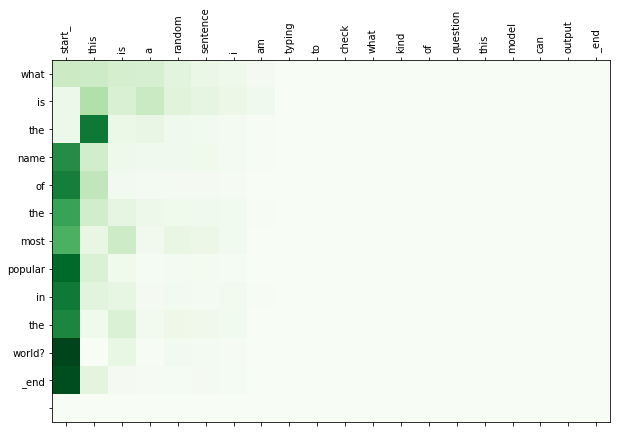

In [36]:
question(u"This is a random sentence I am typing to check what kind of question this model can output")

Input : start_ so this model gives decent results. or maybe after looking at this result, you would beg to disagree _end
predicted sentence :what is the term for the most popular flavoring for the same in the same in the same in the same in the same in the same in the same in the same in the same in the same in the same 


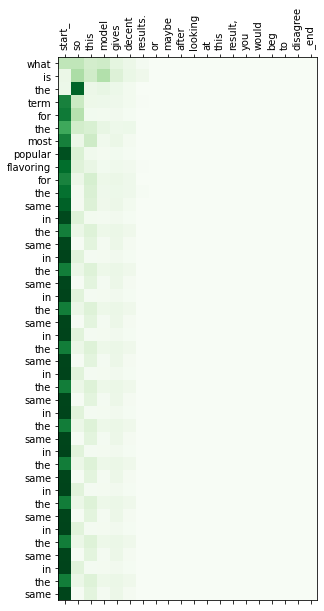

In [64]:
# question(u"So this model results into a decent question with 2 epochs of training but in my opinion the transformers are going to blow my mind")
question("So this model gives decent results. Or maybe after looking at this result, you would beg to disagree")

Input : start_ messi just won the copa america trophy _end
predicted sentence :what was the name of the first commercial market jazz? _end 


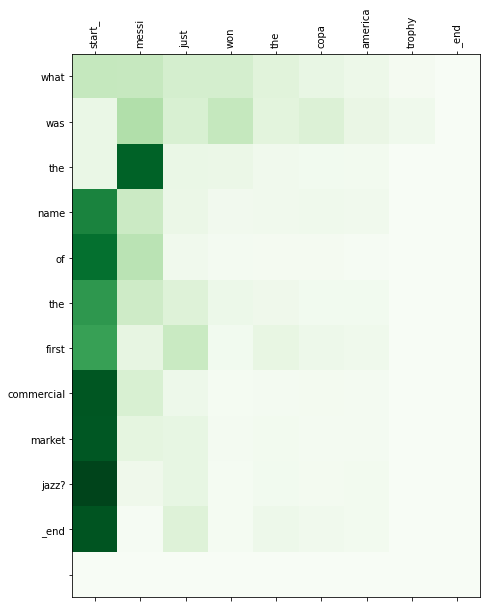

In [41]:
question("Messi just won the copa america trophy")

Input : start_ i can speak the bird language _end
predicted sentence :what is the most popular application of the same in the world? _end 


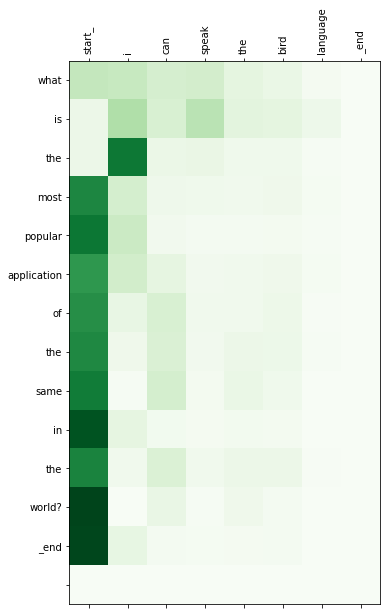

In [52]:
question("I can speak the bird language")

Input : start_ i can speak the bird language but i am not well versed with the knowledge of writing it. looks like i need to focus on my education. this model apparently doesnt put too much attention to the words at the ending or maybe it hasnt been trained enough _end
predicted sentence :what is the most popular application of the same in the world? _end 


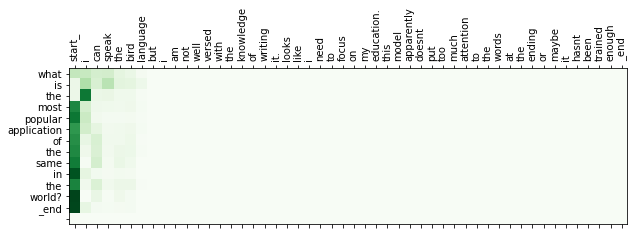

In [57]:
question("I can speak the bird language but I am not well versed with the knowledge of writing it. Looks like I need to focus on my education. This model apparently doesn't put too much attention to the words at the ending or maybe it hasn't been trained enough")